In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import tensorflow as tf
from tensorflow.keras.applications import NASNetLarge
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os

In [3]:
# Directories for training and validation data
train_dir = '/kaggle/input/final-dataset/Train'
val_dir = '/kaggle/input/final-dataset/Test'

In [4]:
# Parameters
img_size = (331, 331)
batch_size = 8
epochs = 15
learning_rate = 0.0001

In [5]:
# Data generators (no resizing since images are already the correct size)
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

In [6]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical')

Found 13980 images belonging to 6 classes.


In [7]:
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical')


Found 5952 images belonging to 6 classes.


In [8]:
# Model setup
base_model = NASNetLarge(weights='imagenet', include_top=False, input_shape=(331, 331, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

343610240/343610240 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [9]:

# Print model summary
print("Model Summary:")
print(model.summary())

Model Summary:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 331, 331, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv1 (Conv2D)       │ (None, 165, 165, 96)   │          2,592 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn1                  │ (None, 165, 165, 96)   │            384 │ stem_conv1[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 165, 165, 96)   │              0 │ stem_bn1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reduction_conv_1_stem_1   │ (None, 165, 165, 42)   │          4,032 │ activation[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reduction_bn_1_stem_1     │ (None, 165, 165, 42)   │            168 │ reduction_conv_1_stem… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 165, 165, 42)   │              0 │ reduction_bn_1_stem_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 165, 165, 96)   │              0 │ stem_bn1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv_1_pad_red… │ (None, 169, 169, 42)   │              0 │ activation_1[0][0]     │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv_1_pad_red… │ (None, 171, 171, 96)   │              0 │ activation_3[0][0]     │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv_1_reducti… │ (None, 83, 83, 42)     │          2,814 │ separable_conv_1_pad_… │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv_1_reducti… │ (None, 83, 83, 42)     │          8,736 │ separable_conv_1_pad_… │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv_1_bn_redu… │ (None, 83, 83, 42)     │            168 │ separable_conv_1_redu… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv_1_bn_redu… │ (None, 83, 83, 42)     │            168 │ separable_conv_1_redu… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 83, 83, 42)     │              0 │ separable_conv_1_bn_r… │
├──────────────────────

 Total params: 84,941,016 (324.02 MB)

 Trainable params: 84,744,348 (323.27 MB)

 Non-trainable params: 196,668 (768.23 KB)

None


In [10]:
# Fine-tuning: unfreeze base model layers
for layer in base_model.layers:
    layer.trainable = True

model.compile(optimizer=SGD(learning_rate=learning_rate, momentum=0.9),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [11]:
# Train the model
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator)

Epoch 1/15
1748/1748 ━━━━━━━━━━━━━━━━━━━━ 1970s 1s/step - accuracy: 0.3225 - loss: 1.5848 - val_accuracy: 0.2786 - val_loss: 1.6834
Epoch 2/15
1748/1748 ━━━━━━━━━━━━━━━━━━━━ 1694s 969ms/step - accuracy: 0.5247 - loss: 1.1290 - val_accuracy: 0.3180 - val_loss: 1.7320
Epoch 3/15
1748/1748 ━━━━━━━━━━━━━━━━━━━━ 1691s 967ms/step - accuracy: 0.6157 - loss: 0.9424 - val_accuracy: 0.3953 - val_loss: 1.5402
Epoch 4/15
1748/1748 ━━━━━━━━━━━━━━━━━━━━ 1692s 968ms/step - accuracy: 0.6640 - loss: 0.8433 - val_accuracy: 0.4874 - val_loss: 1.2619
Epoch 5/15
1748/1748 ━━━━━━━━━━━━━━━━━━━━ 1691s 967ms/step - accuracy: 0.6868 - loss: 0.7736 - val_accuracy: 0.5823 - val_loss: 1.0114
Epoch 6/15
1748/1748 ━━━━━━━━━━━━━━━━━━━━ 1693s 969ms/step - accuracy: 0.7381 - loss: 0.6730 - val_accuracy: 0.6213 - val_loss: 0.9217
Epoch 7/15
1748/1748 ━━━━━━━━━━━━━━━━━━━━ 1696s 970ms/step - accuracy: 0.7705 - loss: 0.5929 - val_accuracy: 0.6714 - val_loss: 0.8267
Epoch 8/15
1748/1748 ━━━━━━━━━━━━━━━━━━━━ 1698s 971ms/step

In [12]:
# Save the model
model_save_path = '/kaggle/working/saved_model.h5'
model.save(model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to /kaggle/working/saved_model.h5


In [13]:
# Save features for future use
feature_extractor = Model(inputs=model.input, outputs=model.layers[-2].output)
train_features = feature_extractor.predict(train_generator, verbose=1)
val_features = feature_extractor.predict(val_generator, verbose=1)

1748/1748 ━━━━━━━━━━━━━━━━━━━━ 428s 237ms/step
744/744 ━━━━━━━━━━━━━━━━━━━━ 170s 229ms/step


In [14]:
with open('/kaggle/working/train_features.pkl', 'wb') as f:
    pickle.dump(train_features, f)

with open('/kaggle/working/val_features.pkl', 'wb') as f:
    pickle.dump(val_features, f)

print("Features saved.")

Features saved.


In [15]:
# Classification report
y_true = val_generator.classes
val_generator.reset()
y_pred = model.predict(val_generator, verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)

class_labels = list(val_generator.class_indices.keys())
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

744/744 ━━━━━━━━━━━━━━━━━━━━ 185s 229ms/step

Classification Report:
              precision    recall  f1-score   support

       anger       0.15      0.13      0.14       992
        fear       0.17      0.12      0.14       992
       happy       0.17      0.16      0.17       992
     neutral       0.20      0.20      0.20       992
         sad       0.17      0.25      0.21       992
    surprise       0.18      0.18      0.18       992

    accuracy                           0.17      5952
   macro avg       0.17      0.17      0.17      5952
weighted avg       0.17      0.17      0.17      5952



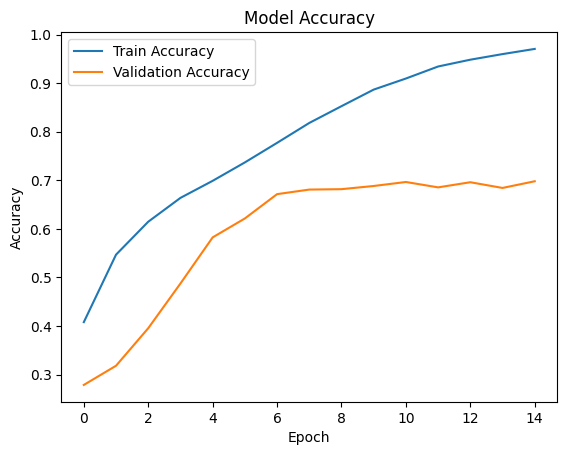

In [16]:
# Plot training history
plt.figure()
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('/kaggle/working/accuracy_plot.png')
plt.show()

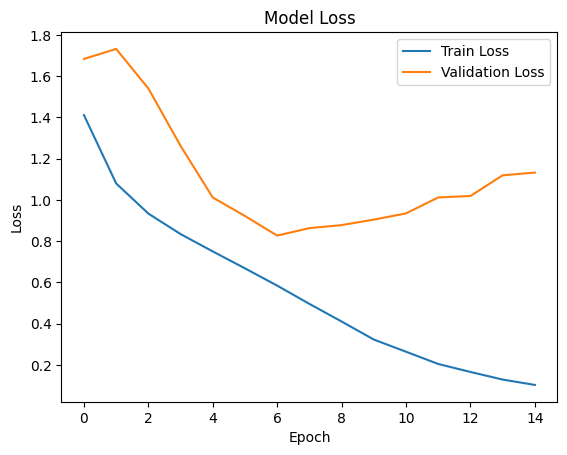

In [17]:
plt.figure()
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('/kaggle/working/loss_plot.png')
plt.show()